<a href="https://colab.research.google.com/github/SirBlackwood/emg_predictive_text_app/blob/main/training_model/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, GlobalAveragePooling1D, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.optimizers import SGD
import tensorflow as tf
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
!mkdir output
!rm -r emg_datasets
!git clone https://github.com/zoders/emg_datasets
%cd /content/emg_datasets/moves
# !rm -r 4

/content
rm: cannot remove 'emg_datasets': No such file or directory
Cloning into 'emg_datasets'...
remote: Enumerating objects: 8814, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 8814 (delta 1), reused 15 (delta 1), pack-reused 8799
Receiving objects: 100% (8814/8814), 226.45 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (8794/8794), done.
/content/emg_datasets/moves


In [ ]:
def get_dataset(dataset_path="/content/emg_datasets/full_dataset"):
  data = []
  labels = []
  muap_paths = []
  for folder in os.listdir(dataset_path):
      for muap_path in os.listdir("{}/{}".format(dataset_path, folder)):
          path = "{}/{}/{}".format(dataset_path, folder, muap_path)
          muap_paths.append(path)
  random.seed(42)
  random.shuffle(muap_paths)
  for muap_path in muap_paths:
      muap = np.loadtxt(muap_path)
      data.append(muap)
      label = muap_path.split(os.path.sep)[-2]
      labels.append(label)
  data = np.asarray(data, dtype=np.float32)
  labels = np.asarray(labels)
  return data, labels

signals, actions = get_dataset("/content/emg_datasets/moves")
signals, actions = signals[:,:], actions[:]

 ...]

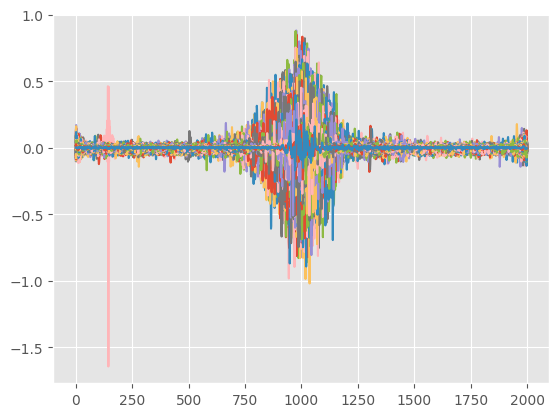

In [ ]:

tmp = np.sum(np.abs(signals), axis=1)
# signals[tmp > 1000, :] = []

signals = np.delete(signals, tmp > 50, axis=0)
actions = np.delete(actions, tmp > 50, axis=0)
plt.plot(signals.T)

In [ ]:
len(signals)

490

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 ...
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_29 (Reshape)        (None, 2000, 1)           0         
                                                                 
 conv1d_145 (Conv1D)         (None, 1801, 40)          8040      
                                                                 
 conv1d_146 (Conv1D)         (None, 1792, 25)          10025     
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 448, 25)          0         
 g1D)                                                            
                                                                 
 conv1d_147 (Conv1D)         (None, 439, 100)          25100     
                                                                 
 conv1d_148 (Conv1D)         (None, 430, 50)   

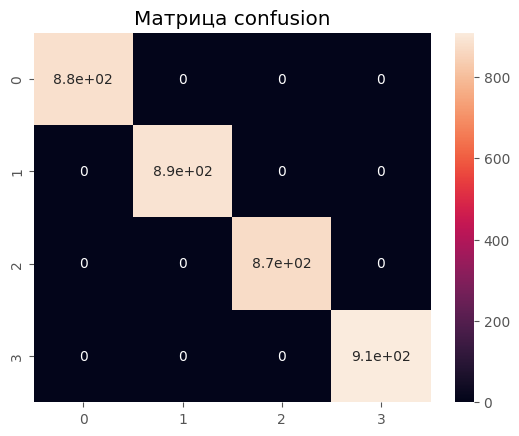

37/37 [==============================] - 0s 3ms/step


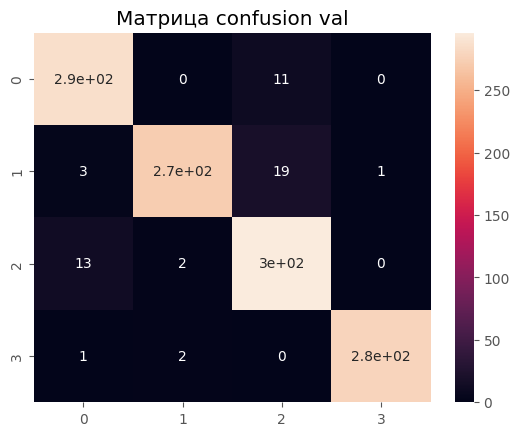

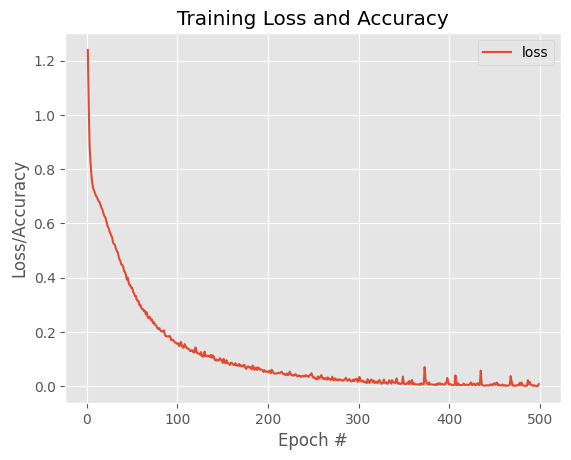

<Figure size 640x480 with 0 Axes>

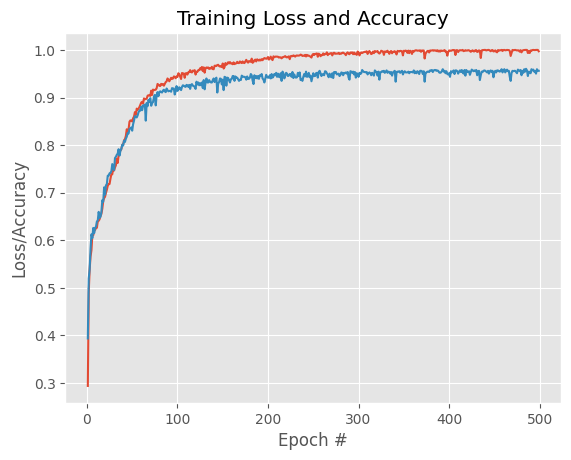

In [ ]:
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sn
with tf.device('/device:GPU:0'):
   # разбиваем данные на обучающую и тестовую выборки, используя 75%
   # данных для обучения и оставшиеся 25% для тестирования
  (trainX, testX, trainY, testY) = train_test_split(signals, actions, test_size=0.25, random_state=42)
  # trainX = signals
  # trainY = actions
  lb = LabelBinarizer()
  trainY = lb.fit_transform(trainY)
  testY = lb.transform(testY)
  num_classes = 4
  num_sensors = 1
  print(trainY)
  input_size = trainX.shape[1]
  model = Sequential()
  model.add(Reshape((input_size, num_sensors), input_shape=(input_size,)))
  model.add(Conv1D(40, 200, activation='relu', input_shape=(input_size, num_sensors)))
  model.add(Conv1D(25, 10, activation='relu'))
  model.add(MaxPooling1D(4))
  model.add(Conv1D(100, 10, activation='relu'))
  model.add(Conv1D(50, 10, activation='relu'))
  model.add(MaxPooling1D(4))
  model.add(Dropout(0.5))
  # next layers will be retrained
  model.add(Conv1D(100, 10, activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(num_classes, activation='softmax'))

  EPOCHS = 500

  print(model.summary())

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(5e-5), metrics=['accuracy'])
  H = model.fit(trainX, trainY,
                      epochs=EPOCHS,
                      # batch_size=32,
                      # steps_per_epoch=len(trainX)//32,
                      validation_data=(testX, testY),
                      # validation_steps=len(testX)//32
                      )
  # predictions = model.predict(testX, batch_size=32)
  # print(classification_report(testY.argmax(axis=1),
    # predictions.argmax(axis=1), target_names=lb.classes_))
  plt.figure()
  trainY_pred = model.predict(trainX)
  matrix = confusion_matrix(trainY.argmax(axis=1), trainY_pred.argmax(axis=1)) # Матрица confusion
  sn.heatmap(matrix, annot=True)
  plt.title('Матрица confusion')
  plt.show()
  plt.figure()
  testY_pred = model.predict(testX)
  matrix = confusion_matrix(testY.argmax(axis=1), testY_pred.argmax(axis=1)) # Матрица confusion
  sn.heatmap(matrix, annot=True)
  plt.title('Матрица confusion val')
  plt.show()
  N = np.arange(1, EPOCHS)
  plt.style.use("ggplot")
  plt.figure()
  H.history["loss"][0] = 1
  # plt.plot(N, H.history["accuracy"], label="train_accuracy")
  plt.plot(N, H.history["loss"][1:], label="loss")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.figure()
  N = np.arange(1, EPOCHS)
  plt.style.use("ggplot")
  plt.figure()
  H.history["accuracy"][0] = 1
  plt.plot(N, H.history["accuracy"][1:], label="train_accuracy")
  plt.plot(N, H.history["val_accuracy"][1:], label="val_accuracy")
  # plt.plot(N, H.history["loss"][1:], label="loss")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.savefig("/content/plot.png")
  model.save("/content/model.h5")
  f = open("/content/lb.pickle", "wb")
  f.write(pickle.dumps(lb))
  f.close()

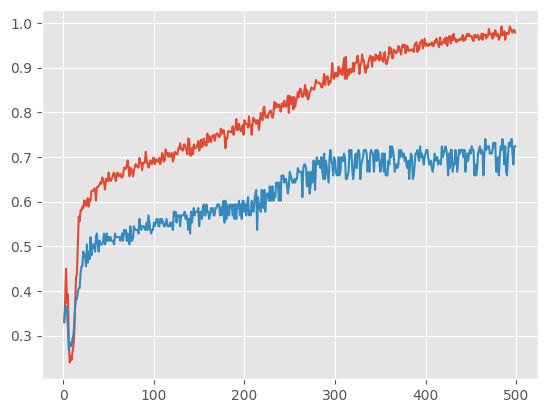

In [ ]:
H.history["accuracy"][0] = 1
plt.plot(N, H.history["accuracy"][1:], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"][1:], label="val_accuracy")
  # plt.plot(N, H.history["loss"][1:], label="loss")

[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]]


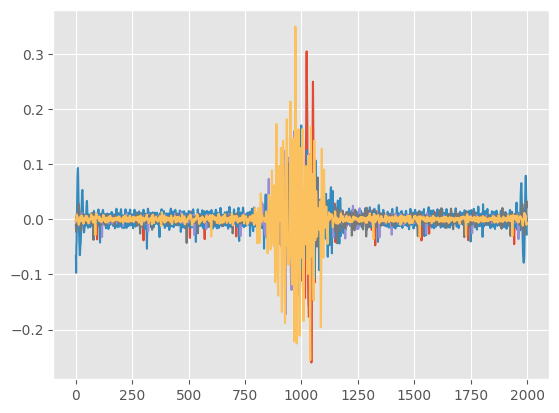

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(signals, actions, test_size=0.25, random_state=42)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
plt.figure()
plt.plot(trainX[:5,:].T)
print(trainY[:5,:])


In [ ]:
from keras.models import load_model
model = load_model("/content/model.h5")
lb = pickle.loads(open("/content/lb.pickle", "rb").read())
sig = np.loadtxt('/path')
preds = model.predict(sig)
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]